Use Google Tesseract, OpenCV and Spacy to:
1. Recognise text in images (tesseract)
2. Idetify personal information etc. with NER from Spacy
3. Be able to draw a box around the personal information, or store it's image coordinates (open CV)
4. Build a dataset of screenshots and the test on these

In [1]:
!pip install pillow
!pip install pytesseract
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=882f96e3230df49b3d2c0a7ea1804aec6ff73f70e78349d2c754a1240e8cc932
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

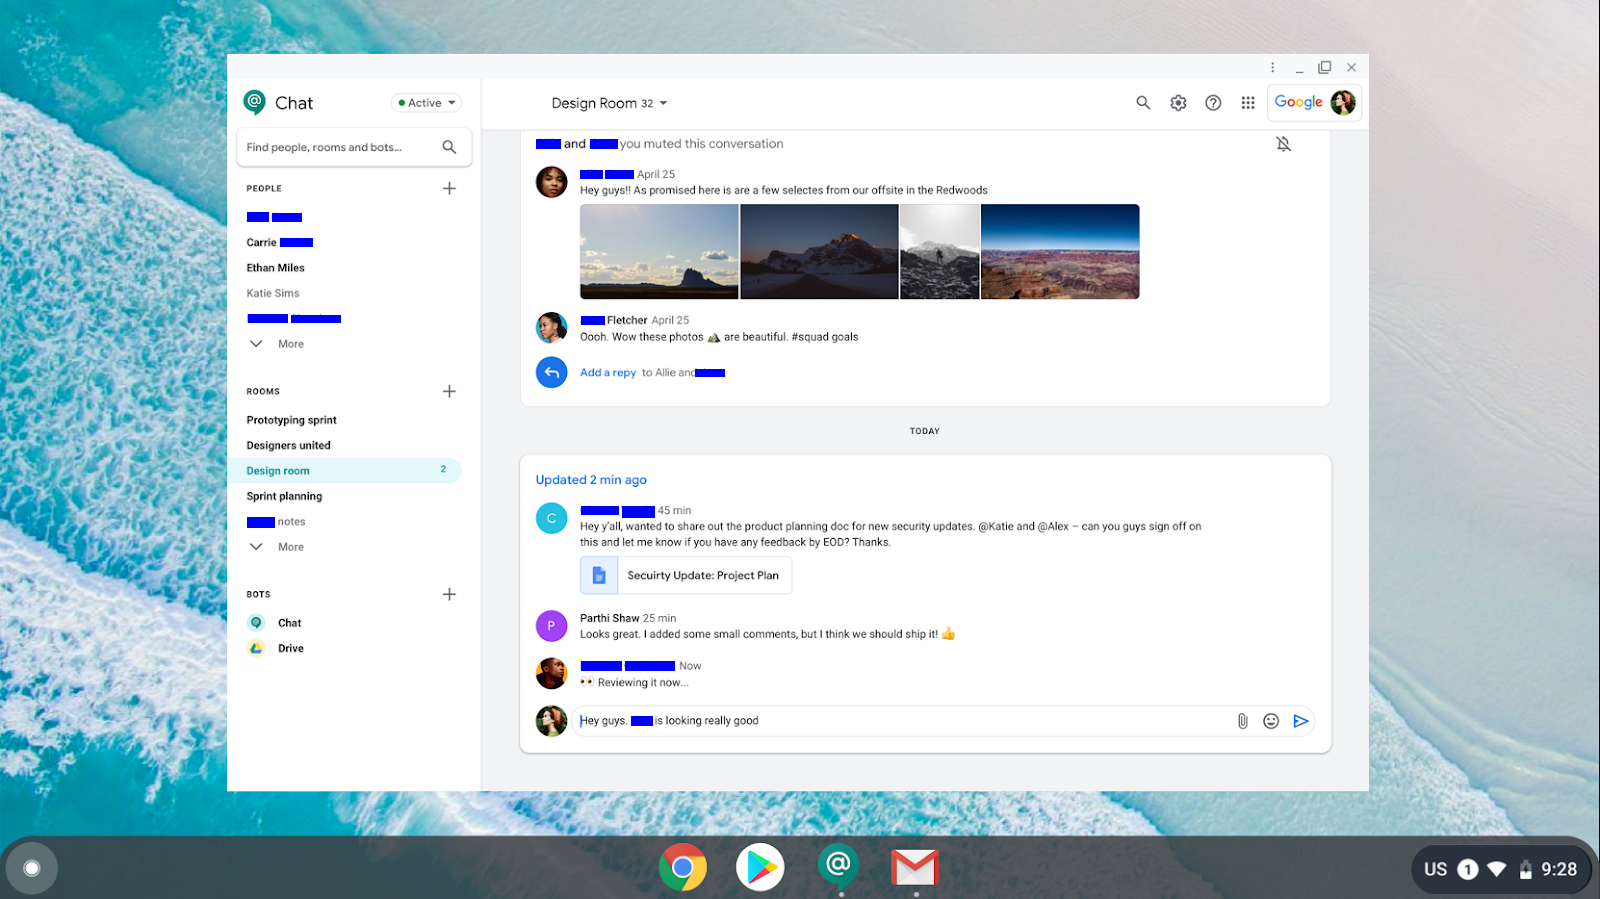

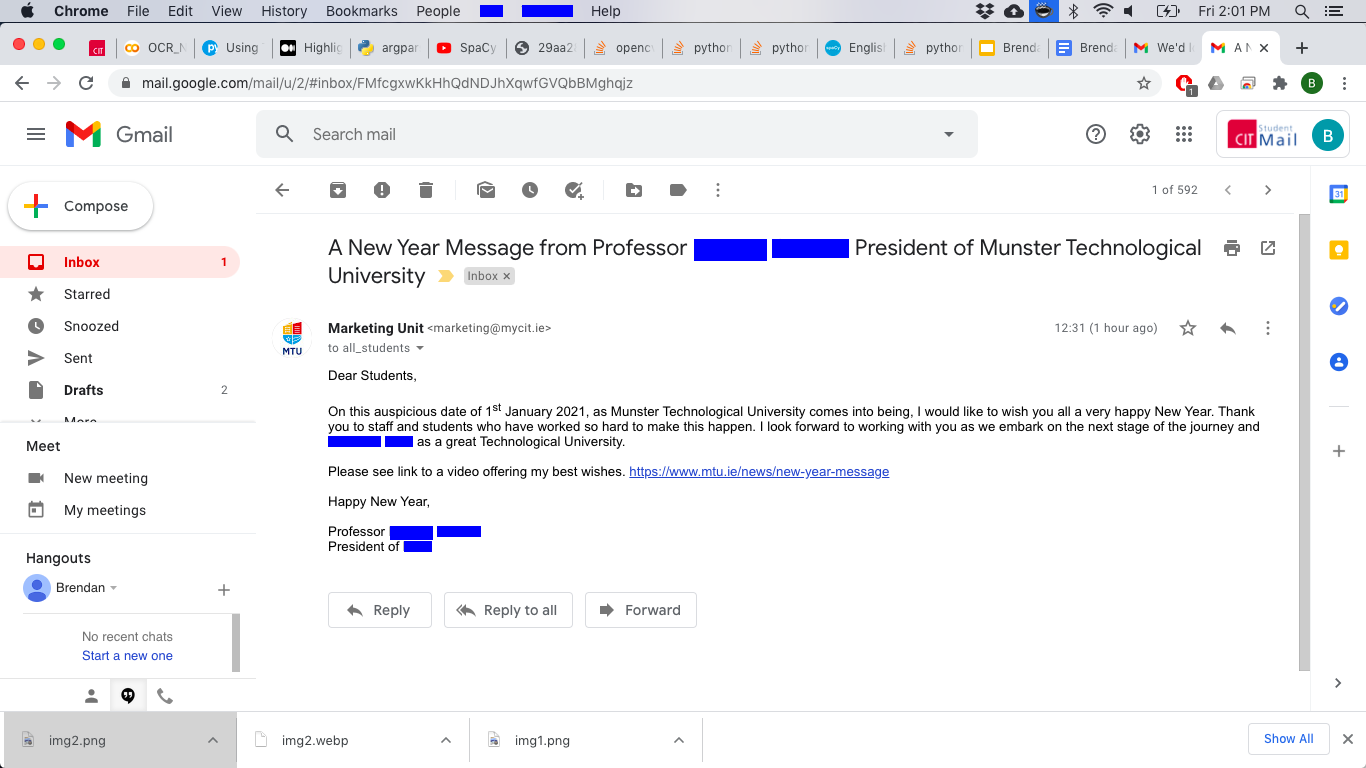

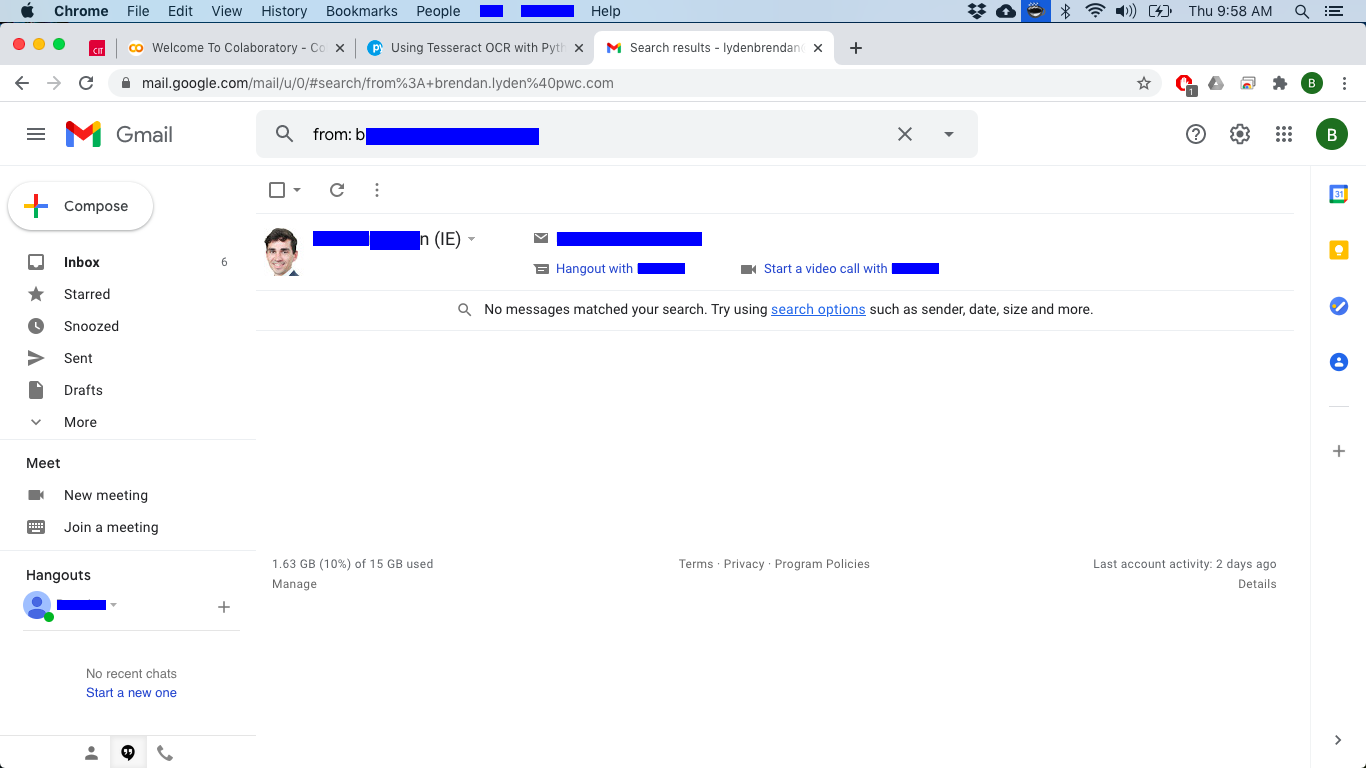

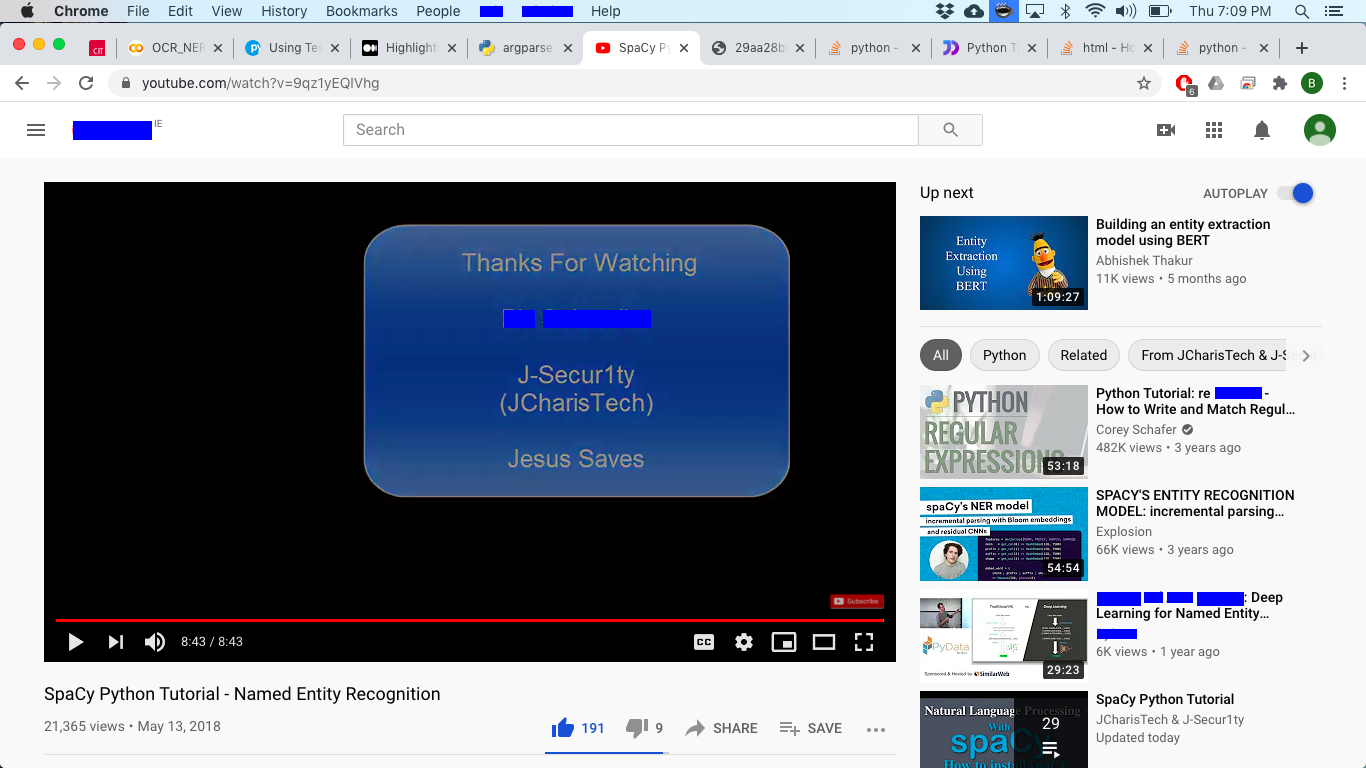

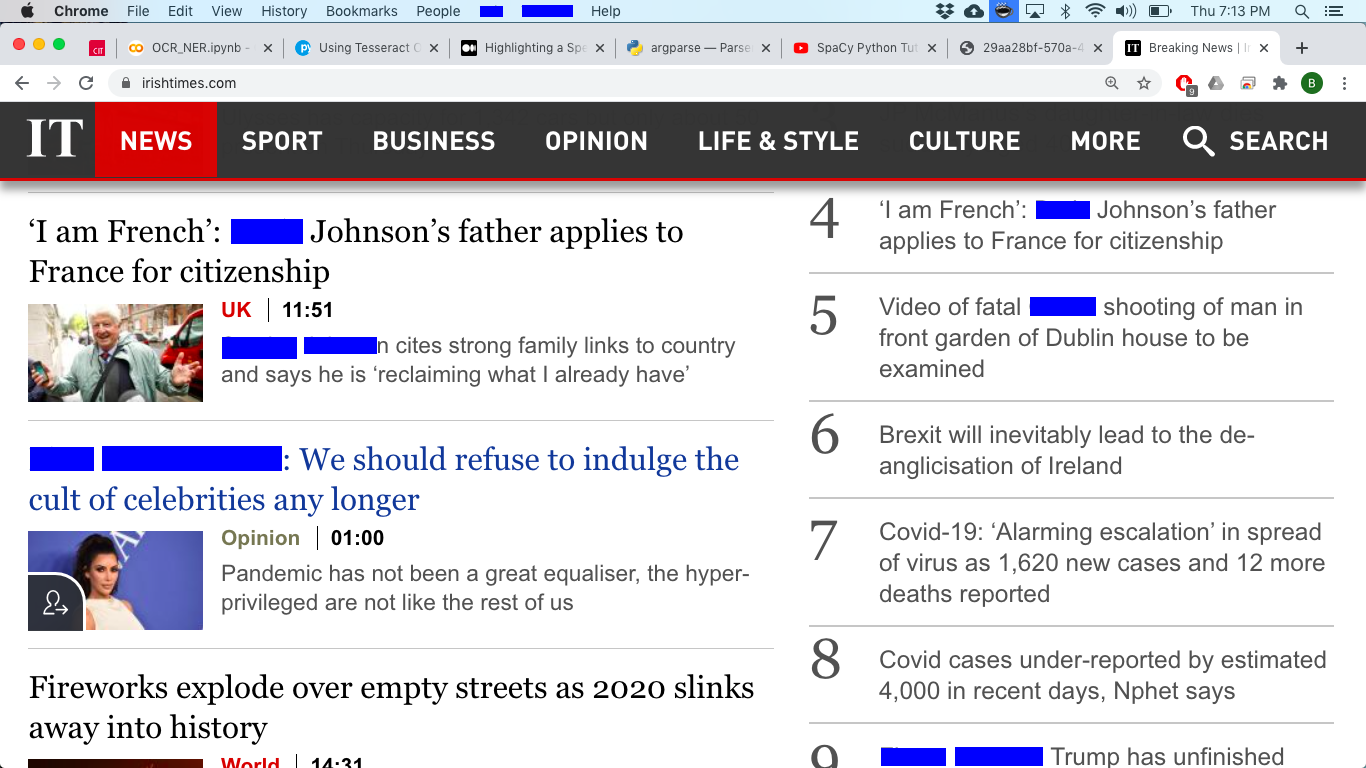

In [2]:
import pytesseract
from pytesseract import Output
import cv2
import re
import spacy
import os
from IPython.display import Image

nlp = spacy.load('en')

tessdata_dir_config = "/usr/share/tesseract-ocr/4.00/tessdata/"
def redact(img_file, alpha=1):
    # alpha is the transparency factor of the redaction
    img = cv2.imread(img_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    strs = pytesseract.image_to_string(img, config='-c preserve_interword_spaces=1')
    d = pytesseract.image_to_data(gray, output_type=Output.DICT, lang='eng', config=tessdata_dir_config)
    n_boxes = len(d['level'])

    split_strs = strs.split('  ')
    NER_dict = {}

    for seq in split_strs:
      data = nlp(seq.strip())
      for word in data.ents:
          NER_dict[re.sub("\W"," ",word.text.lower())] = word.label_

    #print(NER_dict)

    def search(NER_dict, searchFor):
        for key in NER_dict:
            if searchFor in key:
                return NER_dict[key]
        return None

    overlay = img.copy()
    for i in range(n_boxes):
        text = d['text'][i]
        #remove unneeded chars
        text = re.sub("\W"," ",text).lower().strip()
        if re.search('[a-z]', text) and len(text) > 2:
          #print(text)
          if search(NER_dict, text) == 'PERSON':
              #print(text)
              #print(len(text))
              (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
              cv2.rectangle(overlay, (x, y), (x + w, y + h), (255, 0, 0), -1)
            

    alpha = 1  # Transparency factor.
    # Following line overlays transparent rectangle over the image
    img_new = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

    filename = "{}.png".format(os.getpid())
    cv2.imwrite(filename, img_new)
    display(Image(filename))

img_files = ['img1.png', 'img2.png', 'img3.png', 'img4.png', 'img5.png']

for img_file in img_files:
  redact(img_file, alpha=1)
